In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
from imblearn.over_sampling import SMOTE

from sklearn.metrics import precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

In [2]:
%matplotlib inline
warnings.filterwarnings("ignore", category=RuntimeWarning)
os.chdir(r'C:\Users\신상훈\바탕화면\학과\대학원 1-2\통계적 기계학습\머신러닝')

In [3]:
df = pd.read_csv('income_evaluation.csv')

In [4]:
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship',
             'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

df.columns = col_names

df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')

In [5]:
categorical = [var for var in df.columns if df[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

There are 9 categorical variables

The categorical variables are :

 ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income']


In [6]:
df['workclass'].replace(' ?', np.NaN, inplace=True)

In [7]:
df['occupation'].replace(' ?', np.NaN, inplace=True)

In [8]:
df['native_country'].replace(' ?', np.NaN, inplace=True)

In [9]:
df[categorical].isnull().sum()

workclass         1836
education            0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
native_country     583
income               0
dtype: int64

In [10]:
df['workclass'].fillna(df['workclass'].mode()[0], inplace=True)
df['occupation'].fillna(df['occupation'].mode()[0], inplace=True)
df['native_country'].fillna(df['native_country'].mode()[0], inplace=True) 

In [16]:
from sklearn.preprocessing import LabelEncoder

for var in categorical:
    encoder = LabelEncoder()
    encoder.fit(df[var])
    labels = encoder.transform(df[var])
    df[var] = labels

In [17]:
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,6,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,5,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,3,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,3,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,3,338409,9,13,2,9,5,2,0,0,0,40,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,3,257302,7,12,2,12,5,4,0,0,0,38,38,0
32557,40,3,154374,11,9,2,6,0,4,1,0,0,40,38,1
32558,58,3,151910,11,9,6,0,4,4,0,0,0,40,38,0
32559,22,3,201490,11,9,4,0,3,4,1,0,0,20,38,0


In [18]:
X = df.drop(['income'], axis=1)

y = df['income']

In [19]:
y

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: income, Length: 32561, dtype: int32

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [21]:
X_train.shape, X_test.shape

((22792, 14), (9769, 14))

In [23]:
numerical = [col for col in X_train.columns if X_train[col].dtypes != 'O']

numerical

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education_num',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'native_country']

In [24]:
numerical = [col for col in X_train.columns if X_train[col].dtypes != 'O']

numerical

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education_num',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'native_country']

In [25]:
cols = X_train.columns

In [26]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [27]:
X_train = pd.DataFrame(X_train, columns=[cols])

In [28]:
X_test = pd.DataFrame(X_test, columns=[cols])

In [29]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [30]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [31]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[200],
    'max_depth' : [10,12,14], 
    'min_samples_leaf' : [1 ],
    'min_samples_split' : [12,14,16]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_rf = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_rf.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_rf.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_rf.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 200}
최고 예측 정확도: 0.8617


In [32]:
best_rf = grid_rf.best_estimator_
best_rf.fit(X_train,y_train)
best_pred = best_rf.predict(X_test)
get_model_train_eval(best_rf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


오차 행렬
[[6992  415]
 [ 928 1434]]
정확도: 0.8625, 정밀도: 0.7756, 재현율: 0.6071,    F1: 0.6811, AUC:0.9166


In [36]:
ftr_top

capital_gain      0.190526
relationship      0.170521
education_num     0.140225
marital_status    0.119166
age               0.091170
hours_per_week    0.062936
capital_loss      0.052551
education         0.040376
fnlwgt            0.039921
occupation        0.035141
sex               0.021244
workclass         0.020311
native_country    0.008812
race              0.007100
dtype: float64

In [37]:
cols

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country'],
      dtype='object')

In [45]:
ftr1 = ftr_top.reset_index(level = [0]).set_index(['level_0']).index

In [ ]:
ftr_top1 = ['capital_gain','relationship','education_num','marital_status']

<AxesSubplot:title={'center':'Feature importance'}, ylabel='level_0'>

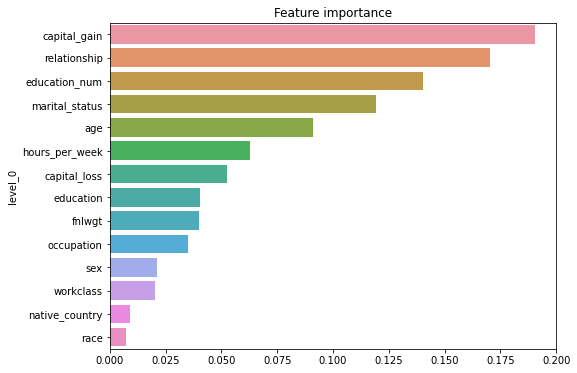

In [46]:
ftr_importance_values = best_rf.feature_importances_
ftr_importance = pd.Series(ftr_importance_values, index = X_train.columns)
ftr_top = ftr_importance.sort_values(ascending = False)

plt.figure(figsize = (8,6))
plt.title('Feature importance')
sns.barplot(x = ftr_top, y = ftr1)